Available in /kaggle/input/:
data4_HGR

Found CSV: /kaggle/input/skin-patches-dataset/data4_HGR/data4_HGR_patches.csv
Loaded 28160 patches, 0 missing
Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8384 - loss: 0.3386 - val_accuracy: 0.9416 - val_loss: 0.1482
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9439 - loss: 0.1521 - val_accuracy: 0.9545 - val_loss: 0.1170
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9552 - loss: 0.1189 - val_accuracy: 0.9638 - val_loss: 0.1090
Epoch 4/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9588 - loss: 0.1115 - val_accuracy: 0.9660 - val_loss: 0.0920
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9674 - loss: 0.0937 - val_accuracy: 0.9652 - val_loss: 0.0923
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9665 - loss: 0.0913 - val_accuracy: 0.9696 - val_loss: 0.0907
Epoch 7/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9625 - l

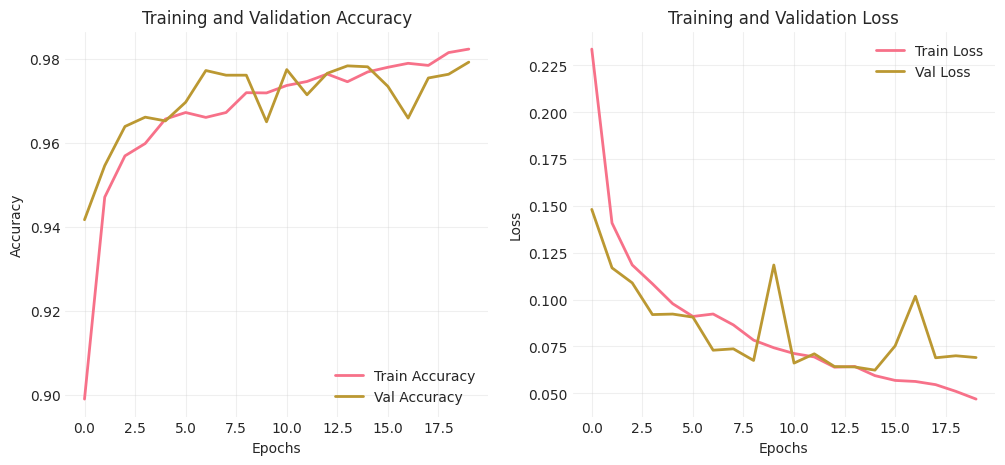

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


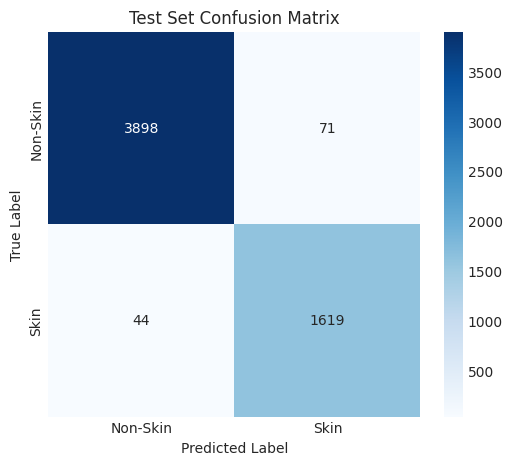


Full Classification Report:
              precision    recall  f1-score   support

    Non-Skin       0.99      0.98      0.99      3969
        Skin       0.96      0.97      0.97      1663

    accuracy                           0.98      5632
   macro avg       0.97      0.98      0.98      5632
weighted avg       0.98      0.98      0.98      5632

880/880 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
880/880 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Saved features to /kaggle/working/predictions_with_ann.csv

Final zip created: /kaggle/working/reconstructions.zip


In [3]:
import pandas as pd
import numpy as np
import os
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# DATA LOADING 
print("Available in /kaggle/input/:")
for item in os.listdir('/kaggle/input/skin-patches-dataset/'):
    print(item)

def find_csv_path(partial_name='data4_HGR_patches.csv'):
    partial_lower = partial_name.lower()
    for root, dirs, files in os.walk('/kaggle/input/skin-patches-dataset/'):
        for file in files:
            if partial_lower in file.lower() and file.endswith('.csv'):
                full_path = os.path.join(root, file)
                print(f"\nFound CSV: {full_path}")
                return full_path
    raise FileNotFoundError("CSV not found")

csv_path = find_csv_path()
df = pd.read_csv(csv_path)


df['image_patch'] = df['image_patch'].str.replace('\\', '/')
dataset_folder = os.path.basename(os.path.dirname(csv_path))
base_input = '/kaggle/input/skin-patches-dataset/' + dataset_folder

if not df['image_patch'].iloc[0].startswith('/kaggle'):
    df['image_patch'] = base_input + '/' + df['image_patch'].str.lstrip('/')

# Label encoding
if 'label' in df.columns and df['label'].dtype == 'object':
    df['label'] = df['label'].map({'no_skin': 0, 'non_skin': 0, 'skin': 1, 'Skin': 1, 'NoSkin': 0}).fillna(0).astype(int)

y = df['label'].values

def load_images(paths):
    images = []
    missing = 0
    for path in paths:
        if os.path.exists(path):
            img = load_img(path, target_size=(16,16))
            img_raw = img_to_array(img)
            images.append(img_raw / 255.0)
        else:
            missing += 1
            images.append(np.zeros((16,16,3)))
    print(f"Loaded {len(images)} patches, {missing} missing")
    return np.array(images)

X = load_images(df['image_patch'].values)

# MODEL ARCHITECTURE 
model = Sequential([
    Input(shape=(16, 16, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='last_conv'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation=None, name='logit') 
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# TRAINING & EVALUATION 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# VISUALIZATION: TRAINING PROGRESS 

plt.figure(figsize=(12, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', lw=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', lw=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', lw=2)
plt.plot(history.history['val_loss'], label='Val Loss', lw=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# VISUALIZATION: CONFUSION MATRIX
test_logits = model.predict(X_test).flatten()
test_preds = (tf.sigmoid(test_logits).numpy() > 0.5).astype(int)


cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Skin', 'Skin'], 
            yticklabels=['Non-Skin', 'Skin'])
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nFull Classification Report:")
print(classification_report(y_test, test_preds, target_names=['Non-Skin', 'Skin']))

# FEATURE EXTRACTION & CSV SAVING 
logits = model.predict(X).flatten()
pred_probs = tf.sigmoid(logits).numpy()
predicted_labels = (pred_probs > 0.5).astype(int)

conv_model = Model(inputs=model.layers[0].input, outputs=model.get_layer('last_conv').output)
conv_maps = conv_model.predict(X)
gap = conv_maps.mean(axis=(1, 2))
ann_energy = np.linalg.norm(gap, axis=1)

pred_df = pd.read_csv(csv_path)  
pred_df['label_ann'] = predicted_labels
pred_df['ann_logit'] = logits
pred_df['ann_conf'] = np.abs(logits)
pred_df['ann_energy'] = ann_energy

pred_csv_path = '/kaggle/working/predictions_with_ann.csv'
pred_df.to_csv(pred_csv_path, index=False)
print(f"\nSaved features to {pred_csv_path}")

# IMAGE RECONSTRUCTION LOOP
recon_dir = '/kaggle/working/reconstructions'
os.makedirs(recon_dir, exist_ok=True)

for image_id in pred_df['image_id'].unique():
    subset = pred_df[pred_df['image_id'] == image_id].reset_index(drop=True)
    n_patches = len(subset)
    if n_patches == 0: continue
    
    cols = int(np.ceil(np.sqrt(n_patches)))
    rows = int(np.ceil(n_patches / cols))
    patch_size = 16
    canvas = np.zeros((rows * patch_size, cols * patch_size, 3), dtype=np.float32)
    green_color = np.array([0, 255, 0], dtype=np.float32)
    alpha = 0.4
    
    current_pos = 0
    for r in range(rows):
        for c in range(cols):
            if current_pos >= n_patches: break
            row_data = subset.iloc[current_pos]
            
            # Re-normalize path for loading
            p_path = row_data['image_patch'].replace('\\', '/')
            if not p_path.startswith('/kaggle'):
                p_path = base_input + '/' + p_path.lstrip('/')
            
            if os.path.exists(p_path):
                patch_img = img_to_array(load_img(p_path)).astype(np.float32)
            else:
                patch_img = np.zeros((16, 16, 3))
            
            y_start, x_start = r * patch_size, c * patch_size
            canvas[y_start:y_start+patch_size, x_start:x_start+patch_size] = patch_img
            
            if row_data['label_ann'] == 1:
                region = canvas[y_start:y_start+patch_size, x_start:x_start+patch_size]
                canvas[y_start:y_start+patch_size, x_start:x_start+patch_size] = (alpha * green_color) + ((1 - alpha) * region)
            current_pos += 1

    canvas = np.clip(canvas, 0, 255).astype(np.uint8)
    output_path = os.path.join(recon_dir, f'{image_id}_segmentation_overlay.png')
    plt.imsave(output_path, canvas)

# Zip output
zip_path = '/kaggle/working/reconstructions.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(recon_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), recon_dir))

print(f"\nFinal zip created: {zip_path}")